In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC ,SVR
from sklearn.metrics import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

# Supress warning messages.
import warnings
warnings.filterwarnings("ignore")

## Load & Quick Overview of Data 

In [2]:
# Load the dataset into a Pandas DataFrame
heart_df = pd.read_csv('heart_2020_cleaned.csv')
heart_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# Find the dimensions (number of rows and columns) of the data frame along with other informations

num_rows, num_cols = heart_df.shape
print("\nNumber of rows in the Data Frame    : ", num_rows)
print("Number of columns in the Data Frame : ", num_cols)
print("\n")

#Information about dataframe
heart_df.info(verbose= True, show_counts= True)



Number of rows in the Data Frame    :  319795
Number of columns in the Data Frame :  18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 

The dataset contains no missing values, making all columns essential. It comprises 319,795 entries and 18 columns. Key attributes include 'HeartDisease' as the target variable, 'BMI' as a continuous feature, and various categorical features such as 'Smoking,' 'AlcoholDrinking,' 'Stroke,' 'DiffWalking,' 'Sex,' 'AgeCategory,' 'Race,' 'Diabetic,' 'PhysicalActivity,' 'GenHealth,' 'Asthma,' 'KidneyDisease,' and 'SkinCancer.' The dataset employs both float64 and object data types, with a memory usage of approximately 43.9 MB.

In [4]:
# Check for duplicates 
heart_df.duplicated().sum()

18078

In [5]:
# Drop the duplicates
heart_df.drop_duplicates(inplace=True)

In [6]:
# Shape of dataframe after clean up.
heart_df.shape

(301717, 18)

\newpage

In [7]:
#get summary statistics of the numerical data
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,301717.0,28.441970,6.468134,12.02,24.03,27.41,31.65,94.85
PhysicalHealth,301717.0,3.572298,8.140656,0.00,0.00,0.00,2.00,30.00
MentalHealth,301717.0,4.121475,8.128288,0.00,0.00,0.00,4.00,30.00
SleepTime,301717.0,7.084559,1.467122,1.00,6.00,7.00,8.00,24.00


In [8]:
#get summary statistics of the non-numerical data
heart_df.describe(include = ['O'])

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,301717,301717,301717,301717,301717,301717,301717,301717,301717,301717,301717,301717,301717,301717
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,No,No,No,No,No,Female,65-69,White,No,Yes,Very good,No,No,No
freq,274456,174312,280136,289653,257362,159671,31670,227724,251796,230412,104796,259066,289941,272425


## Exploratory Data Analysis

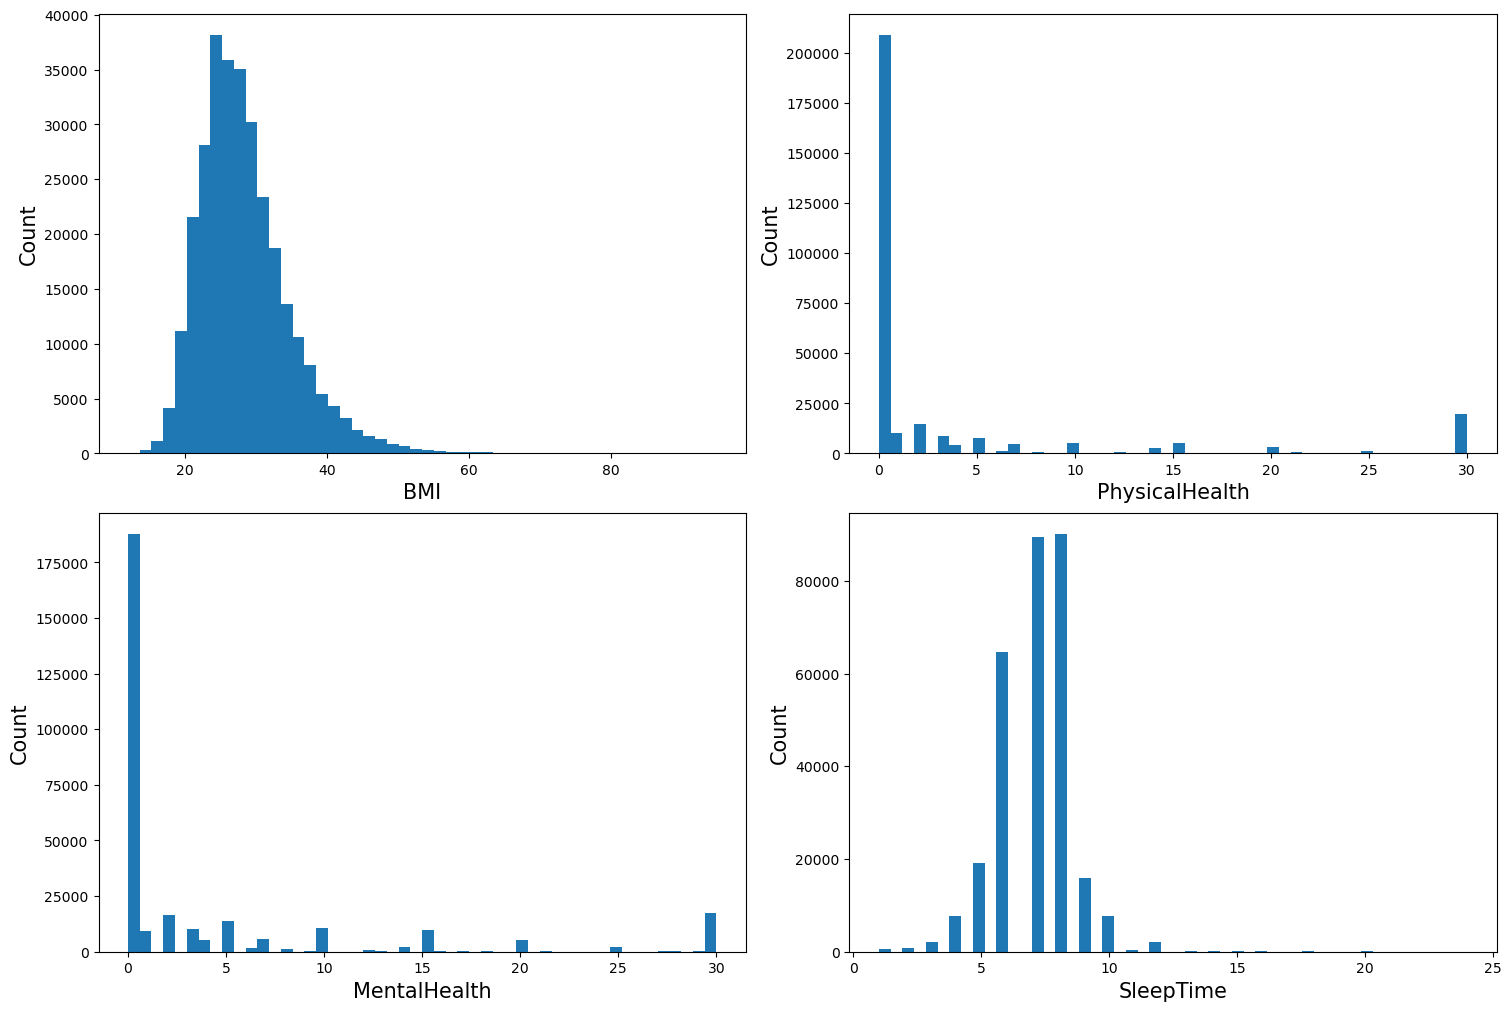

In [9]:
# Histograms of the numerical features
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,10),constrained_layout=True)

ax1.hist(heart_df['BMI'].dropna(), bins=50)
ax1.set_xlabel('BMI', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)

ax2.hist(heart_df['PhysicalHealth'].dropna(), bins=50)
ax2.set_xlabel('PhysicalHealth', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)

ax3.hist(heart_df['MentalHealth'].dropna(), bins=50)
ax3.set_xlabel('MentalHealth', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)

ax4.hist(heart_df['SleepTime'].dropna(), bins=50)
ax4.set_xlabel('SleepTime', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)

plt.show()

The visualizations reveal that the heart disease dataset portrays overall good health, characterized by a predominant presence of individuals with a BMI within the normal range. Additionally, both Physical and Mental Health scores are clustered around the mean, indicating a relatively balanced distribution. However, the distribution of Sleep Time exhibits a right-skewed pattern, suggesting that a majority of individuals in the dataset sleep for less than 7.5 hours per night, with a median Sleep Time below this threshold

\newpage

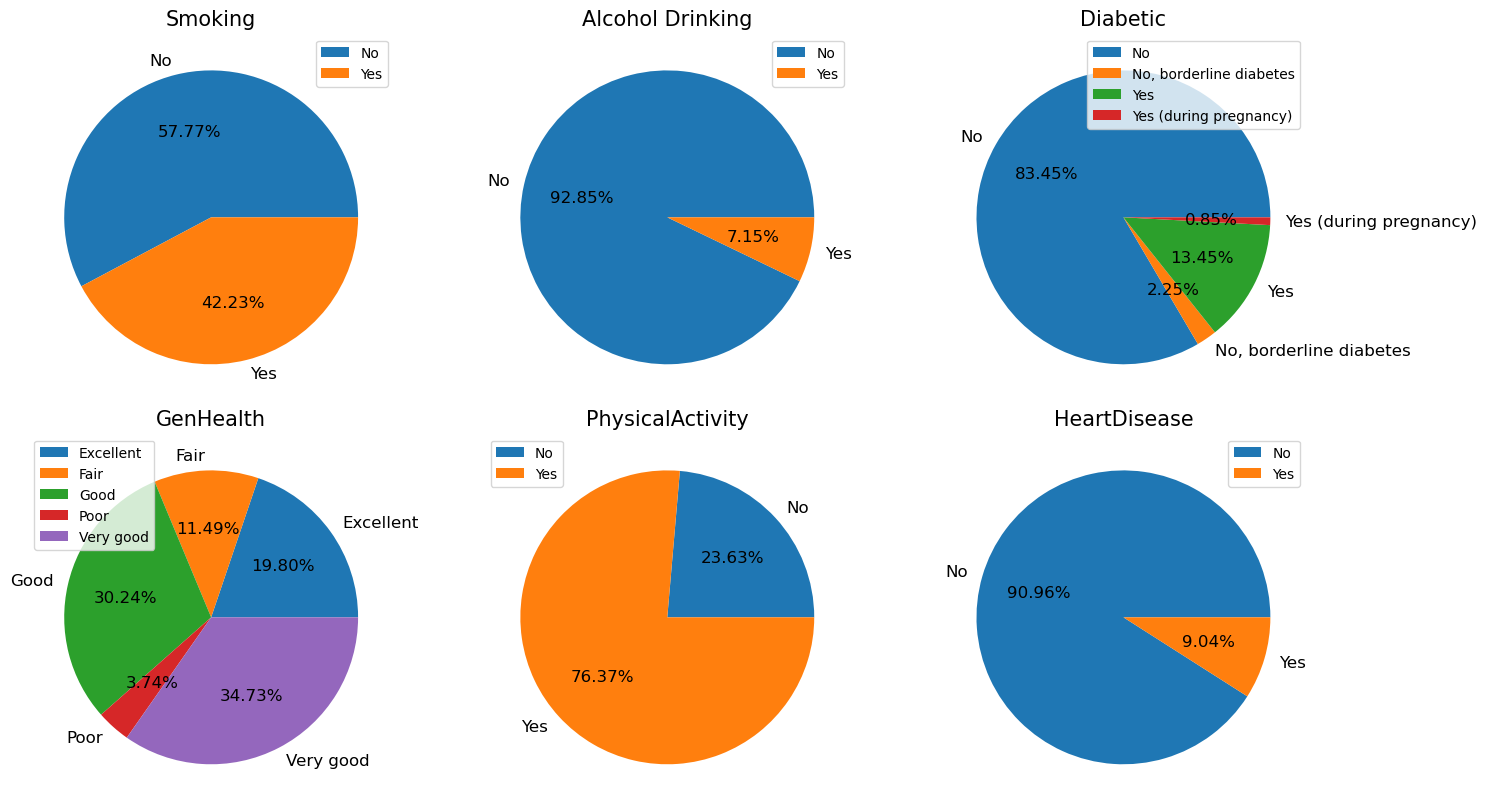

In [10]:
# Pie graphs of the categorical features to analyze the data distribution
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,8),constrained_layout=True)

##Smoking
X_Smoking = heart_df.groupby('Smoking').size().reset_index(name='Counts')['Smoking']
Y_Smoking = heart_df.groupby('Smoking').size().reset_index(name='Counts')['Counts']
ax1.pie(Y_Smoking, labels = X_Smoking, autopct='%.2f%%',textprops={'fontsize':12})
ax1.set_title('Smoking', fontsize=15)
ax1.legend()

## Alcohol Drinking
X_Alcohol = heart_df.groupby('AlcoholDrinking').size().reset_index(name='Counts')['AlcoholDrinking']
Y_Alcohol = heart_df.groupby('AlcoholDrinking').size().reset_index(name='Counts')['Counts']
ax2.pie(Y_Alcohol, labels = X_Alcohol, autopct='%.2f%%',textprops={'fontsize':12})
ax2.set_title('Alcohol Drinking', fontsize=15)
ax2.legend()

## Diabetic
X_Alcohol = heart_df.groupby('Diabetic').size().reset_index(name='Counts')['Diabetic']
Y_Alcohol = heart_df.groupby('Diabetic').size().reset_index(name='Counts')['Counts']
ax3.pie(Y_Alcohol, labels = X_Alcohol, autopct='%.2f%%',textprops={'fontsize':12})
ax3.set_title('Diabetic', fontsize=15)
ax3.legend(loc='upper right')

## GenHealth
X_GenHealth = heart_df.groupby('GenHealth').size().reset_index(name='Counts')['GenHealth']
Y_GenHealth = heart_df.groupby('GenHealth').size().reset_index(name='Counts')['Counts']
ax4.pie(Y_GenHealth, labels = X_GenHealth, autopct='%.2f%%',textprops={'fontsize': 12})
ax4.set_title('GenHealth', fontsize=15)
ax4.legend(loc='upper left')

## PhysicalActivity
X_PhysicalActivity = heart_df.groupby('PhysicalActivity').size().reset_index(name='Counts')['PhysicalActivity']
Y_PhysicalActivity = heart_df.groupby('PhysicalActivity').size().reset_index(name='Counts')['Counts']
ax5.pie(Y_PhysicalActivity, labels = X_PhysicalActivity, autopct='%.2f%%',textprops={'fontsize': 12})
ax5.set_title('PhysicalActivity', fontsize=15)
ax5.legend()

## HeartDisease
X_HeartDisease = heart_df.groupby('HeartDisease').size().reset_index(name='Counts')['HeartDisease']
Y_HeartDisease = heart_df.groupby('HeartDisease').size().reset_index(name='Counts')['Counts']
ax6.pie(Y_HeartDisease, labels = X_HeartDisease, autopct='%.2f%%',textprops={'fontsize': 12})
ax6.set_title('HeartDisease', fontsize=15)
ax6.legend()


The heart disease dataset predominantly comprises individuals with commendable health habits, including abstaining from smoking, occasional alcohol consumption, and regular exercise. Nonetheless, a minority exhibits less favorable health behaviors, such as habitual smoking, excessive alcohol intake, and a lack of physical activity. Encouragingly, adopting healthier lifestyles, characterized by avoiding these detrimental habits, can significantly reduce the risk of heart disease among individuals

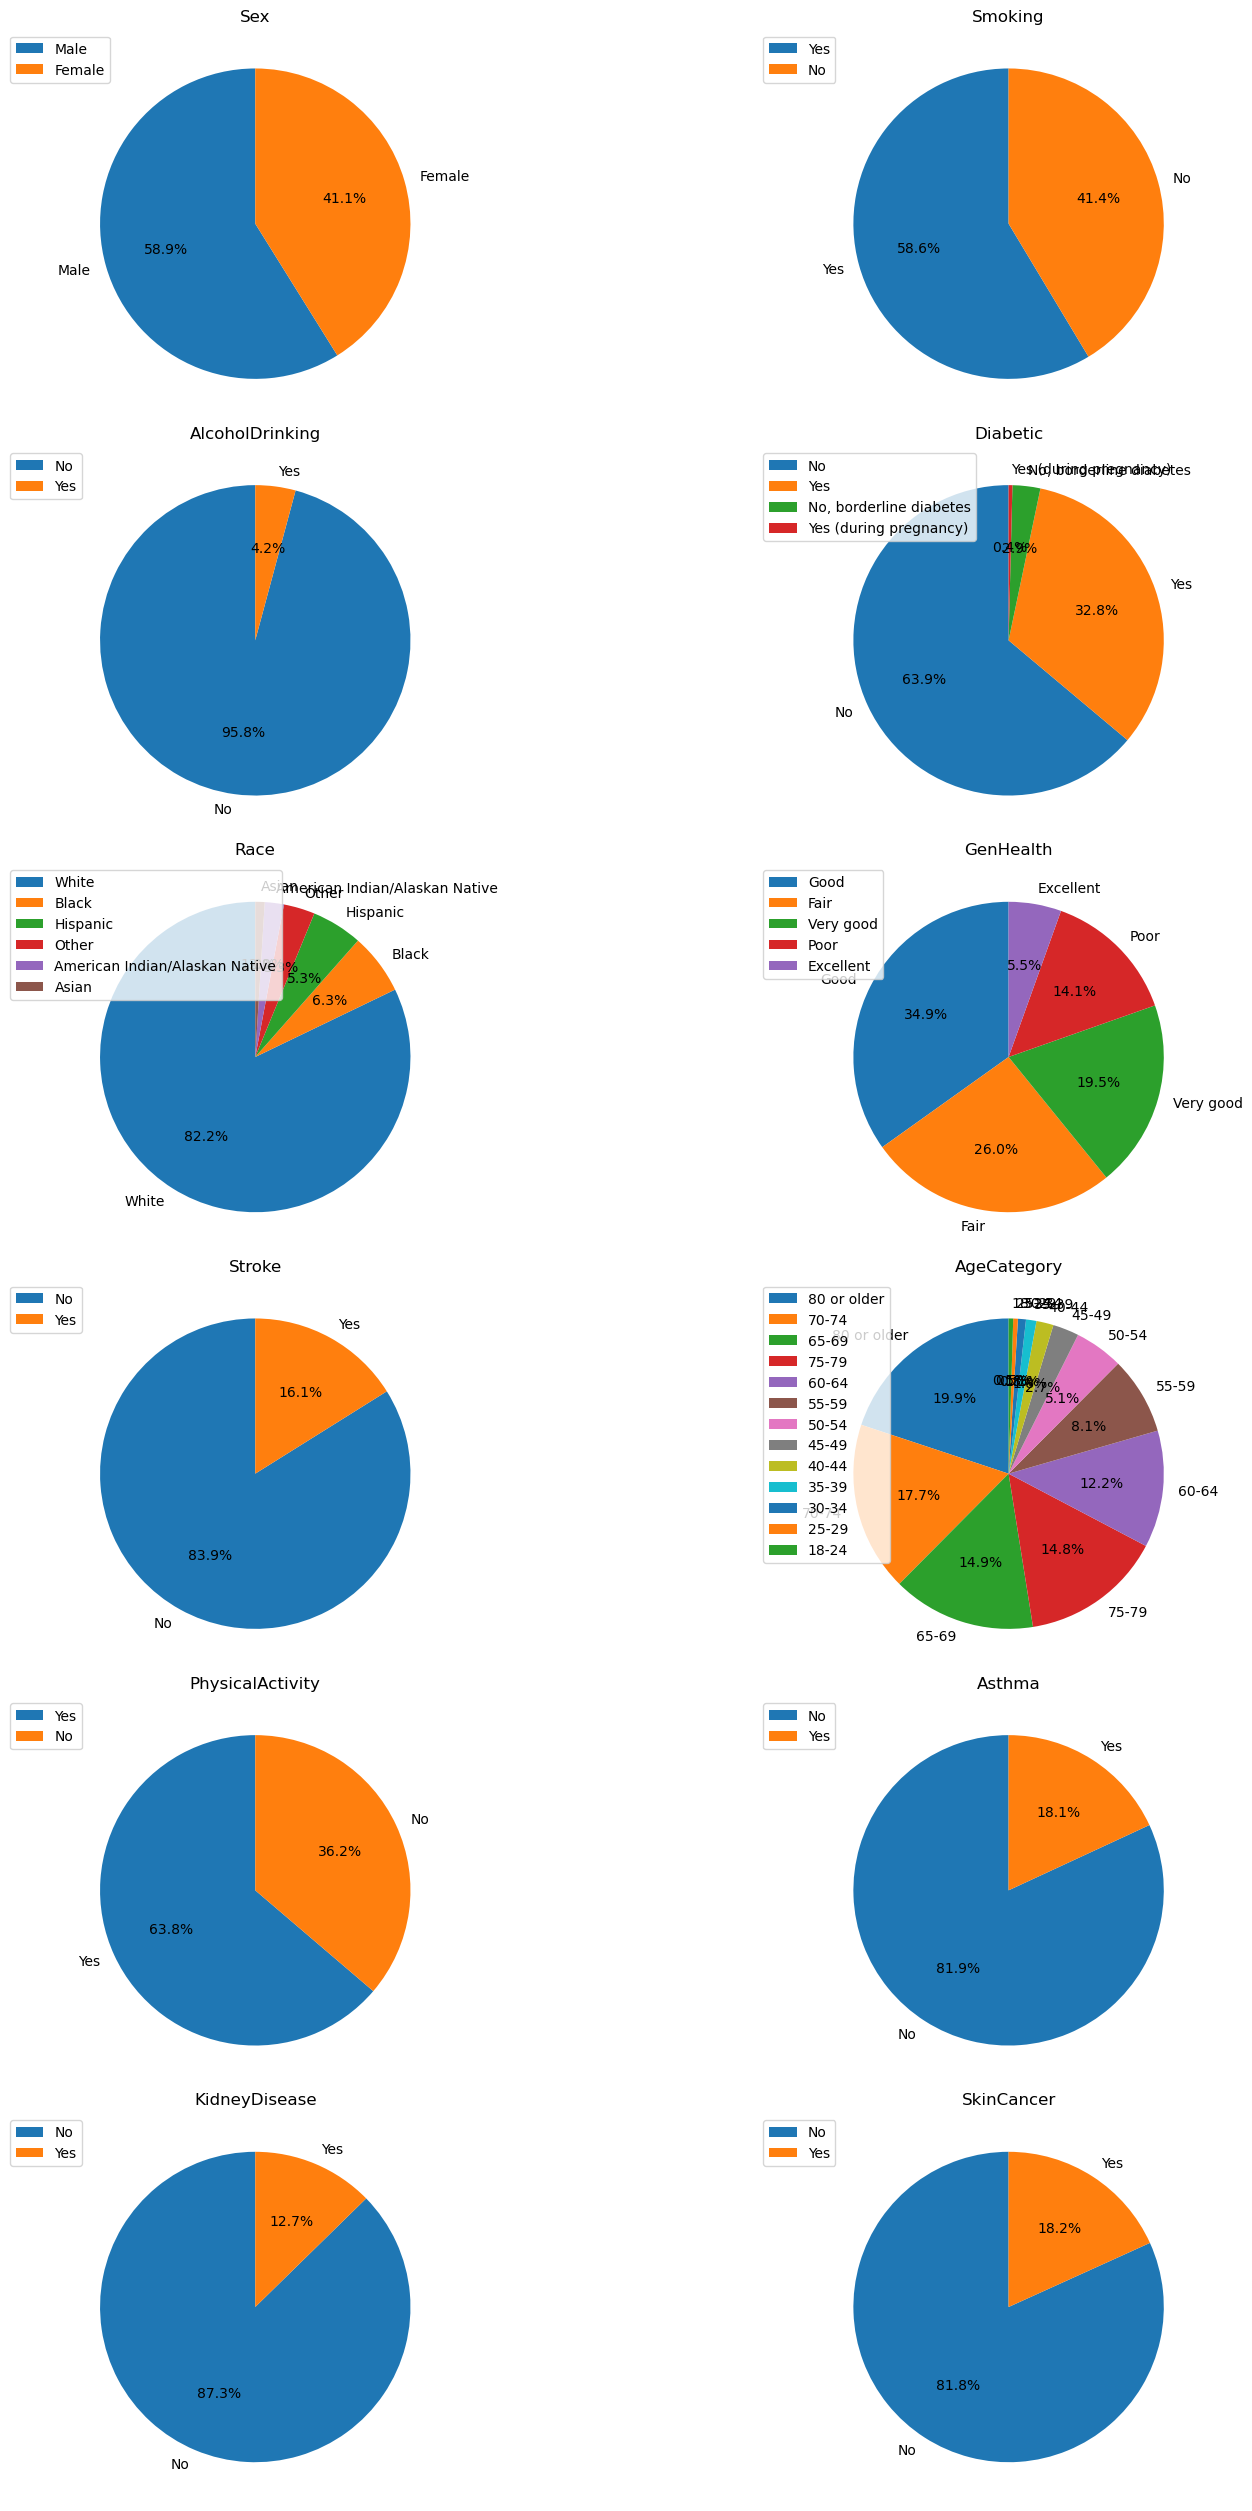

In [79]:
# Categorical Features vs Positive Heart Disease Cases

colors = ['#1f77b4', '#ff7f0e']  # Blue and orange colors

# Filter out only positive cases of HeartDisease
positive_heart_df = heart_df[heart_df['HeartDisease'] == 'Yes']



# Define custom color palette for legend entries
legend_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']



# Create subplots
fig, axs = plt.subplots(6, 2, figsize=(15, 25), constrained_layout=True)



# Define column names
columns = ["Sex", "Smoking", "AlcoholDrinking", "Diabetic", "Race",
           "GenHealth", "Stroke", "AgeCategory", "PhysicalActivity", 
           "Asthma", "KidneyDisease", "SkinCancer"]


# Flatten the axis array for easier iteration
axs = axs.flatten()



# Iterate over each column
for ax, column in zip(axs, columns):
   
    # Get value counts for current column among positive HeartDisease cases
    column_counts = positive_heart_df[column].value_counts()
    
    # Plot pie chart with custom color palette
    ax.pie(column_counts, labels=column_counts.index, autopct='%1.1f%%', colors=legend_colors[:len(column_counts)], startangle=90)
    ax.set_title(column)
    
    # Move legend to the left
    ax.legend(loc='upper left', bbox_to_anchor=(-0.15, 1))

plt.show()


Among all heart disease patients, 58.6% are smokers, while 41.4% are non-smokers. Additionally, among heart disease cases, there is a higher prevalence among males, with 58.9% affected compared to females. Furthermore, regarding race, 82.2% of individuals with heart disease are of the White race.

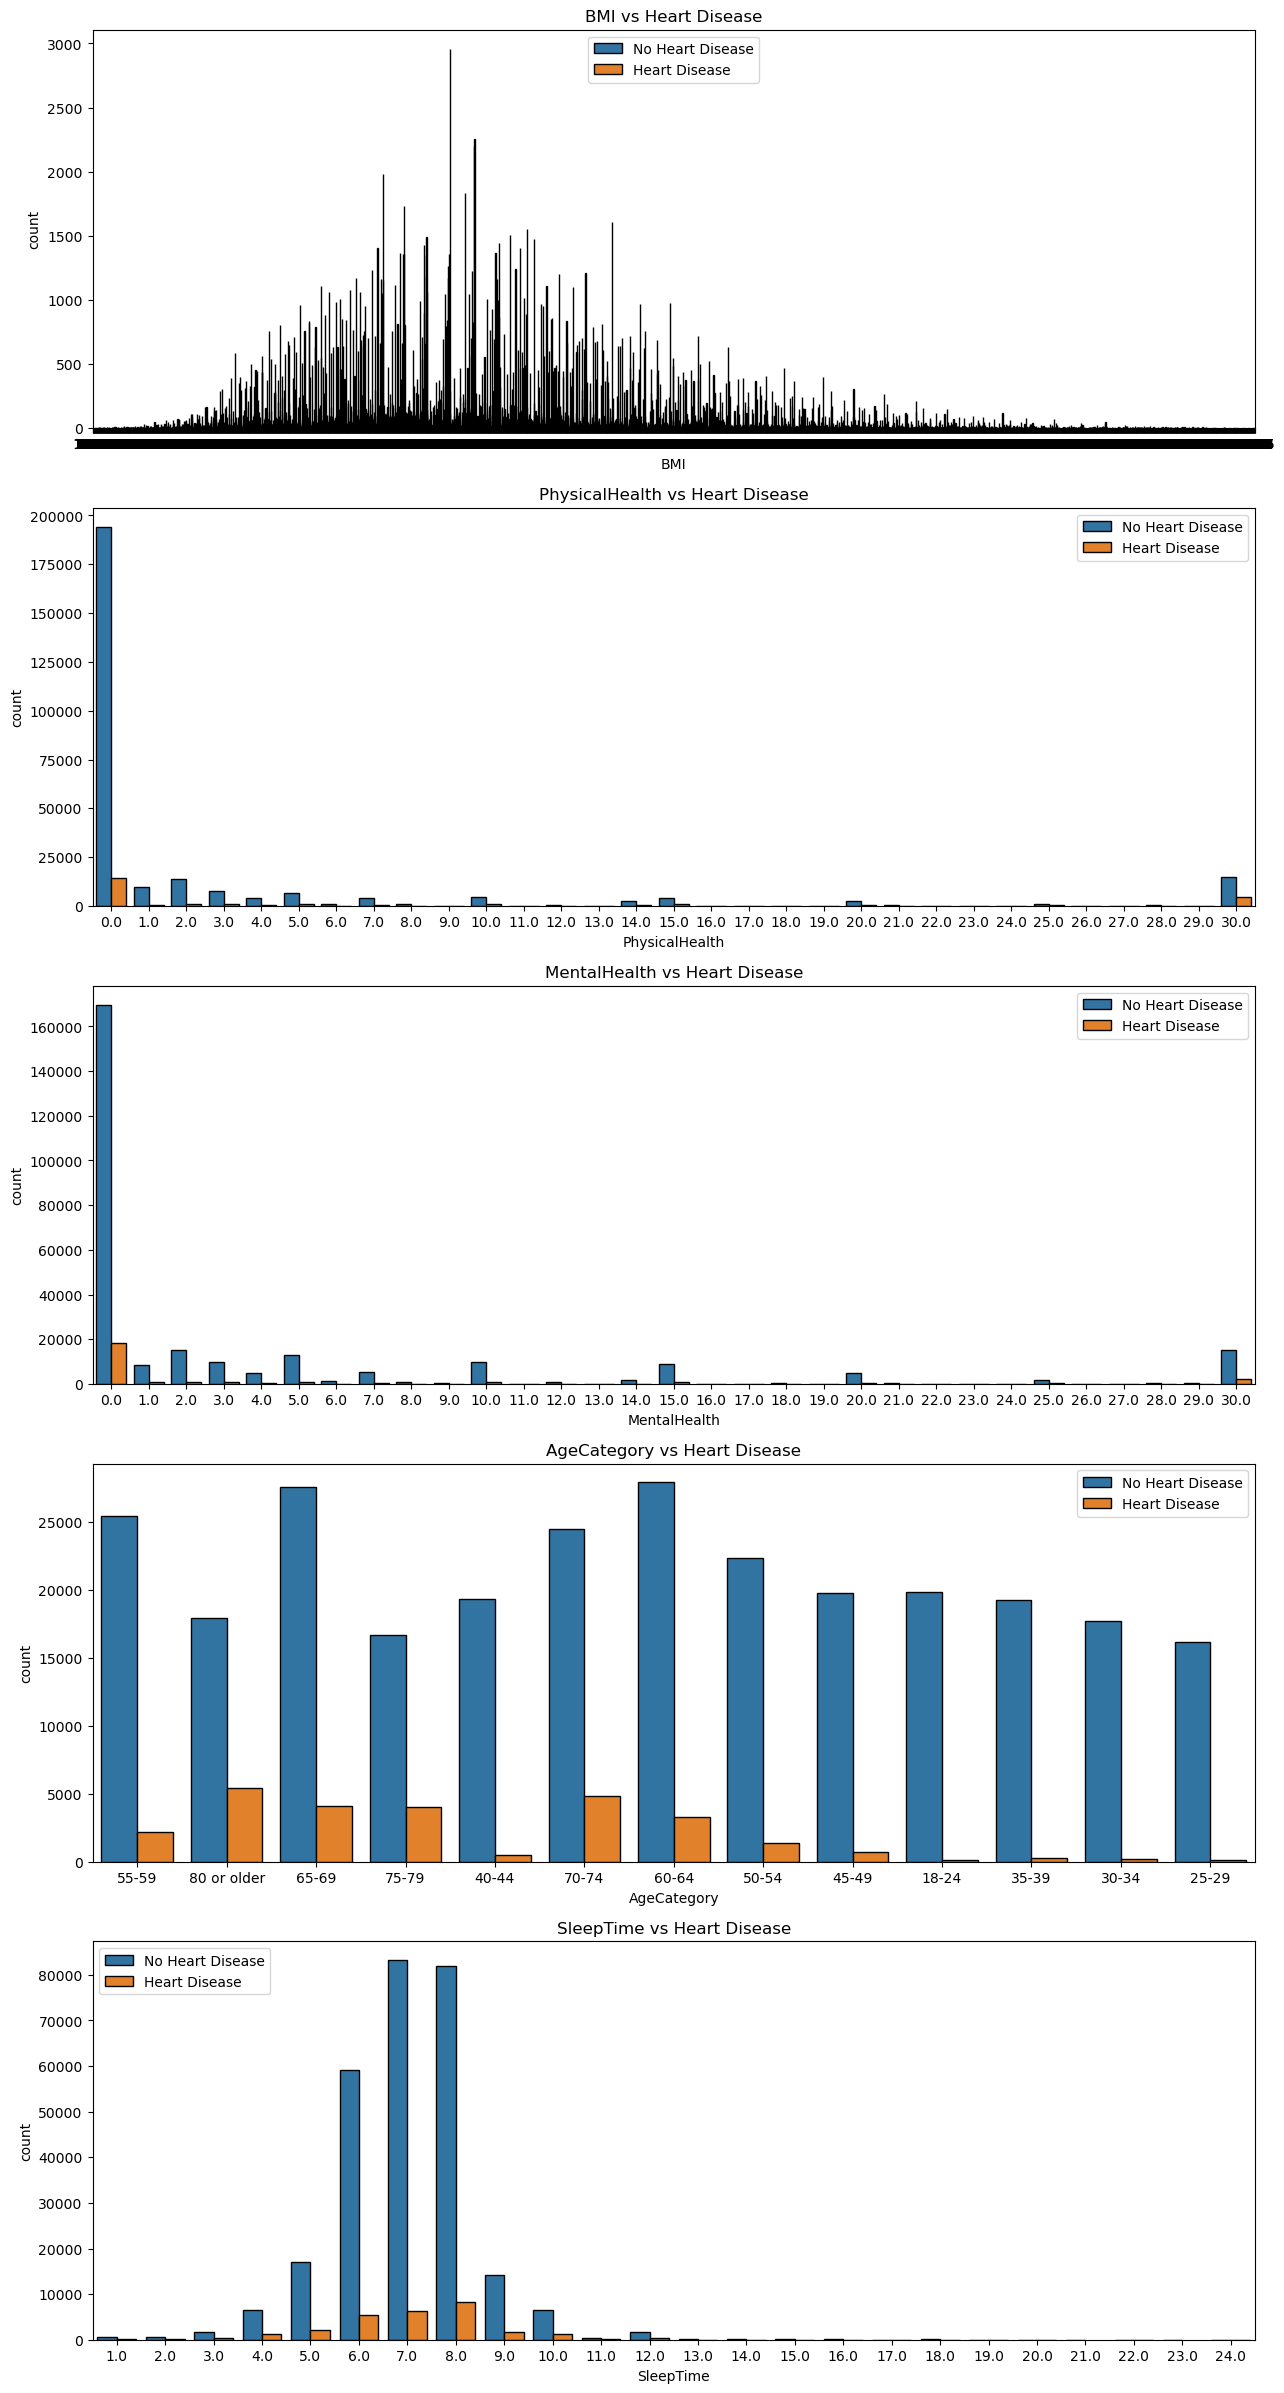

In [12]:
# Numerical Features vs Target Variable (HeartDisease)

numerical_features = ["BMI", "PhysicalHealth", "MentalHealth", "AgeCategory", "SleepTime" ]

fig, ax = plt.subplots(nrows = 5,ncols = 1,figsize = (15,30))

for i in range(len(numerical_features)):
    
    plt.subplot(5,1,i+1)
    
    sns.countplot(x=numerical_features[i],data = heart_df,hue = "HeartDisease",
                  palette = colors, edgecolor = 'black')
    
    title = numerical_features[i] + ' vs Heart Disease'
    
    plt.legend(['No Heart Disease','Heart Disease'])
    
    plt.title(title);

These observations indicate that specific risk factors are more prevalent among individuals with heart disease, including being female, reporting fair or poor general health, and belonging to an older age category. However, it's essential to recognize that these trends represent general patterns, and there are instances where individuals with heart disease may not align with these characteristics.

## Data Preparation

In [13]:
# Let's see number of Unique values in the categorical columns
heart_df.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

##### Binary Categories:

‘HeartDisease,’ ‘Smoking,’ ‘AlcoholDrinking,’ ‘Stroke,’ ‘DiffWalking,’ ‘Sex,’ ‘PhysicalActivity,’
‘Asthma,’ ‘KidneyDisease,’ and ‘SkinCancer’ all have 2 unique values, indicating binary categories.

##### Multiclass Categories:

‘AgeCategory’ has 13 unique values, ‘Race’ has 6 unique values, ‘Diabetic’ has 4 unique values, and
‘GenHealth’ has 5 unique values, suggesting multiclass categorical variables. 

##### Continuous Variables:

‘BMI’ has a substantial 3604 unique values, indicating a wide range of body mass index values.
‘PhysicalHealth,’ ‘MentalHealth,’ and ‘SleepTime’ have 31, 31, and 24 unique values, respectively,
suggesting a broader spectrum of numerical data.

\newpage

In [14]:
# Get the distribution of respondents with/without heart disease
print('\nNumber of respondents with/without heart disease: ','\n',(heart_df['HeartDisease']).value_counts())


Number of respondents with/without heart disease:  
 No     274456
Yes     27261
Name: HeartDisease, dtype: int64


The dataset demonstrates an imbalance in sample distribution between individuals with and without Heart Disease. Specifically:

No Heart Disease (Class 0): 292,422 respondents
Heart Disease (Class 1): 27,373 respondents

To rectify this imbalance, oversampling techniques can be utilized to ensure a more balanced representation of both classes. This rebalancing is crucial for training models capable of accurately generalizing across both outcomes.

In [15]:
# Let's create new copy of the dataframe , execute oversampling, encodings, create dummies and scaling the 
# continuous columns 
heart_df_cp = heart_df.copy()

In [16]:
# Oversampling to correct the imbalance dataset
class_0 = heart_df_cp[heart_df_cp['HeartDisease'] == 'No']
class_1 = heart_df_cp[heart_df_cp['HeartDisease'] == 'Yes']
class_1 = class_1.sample(len(class_0),replace=True)
heart_df_cp = pd.concat([class_0, class_1], axis=0)

print('Data in Heart Dataset:')
print(heart_df_cp['HeartDisease'].value_counts())


Data in Heart Dataset:
No     274456
Yes    274456
Name: HeartDisease, dtype: int64


This demonstrates a balanced dataset achieved through oversampling, ensuring an equal number of samples for both classes. Achieving balance is pivotal for training models capable of effectively learning patterns and making accurate predictions for both outcomes

In [17]:
# Integer encoding for categorical columns having 2 unique values
le = LabelEncoder()
for col in ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke','DiffWalking', 'PhysicalActivity', 
            'Asthma', 'Sex' ,  'KidneyDisease','SkinCancer']:
    
    heart_df_cp[col] = le.fit_transform(heart_df_cp[col])

In [18]:
# Create Dummies for the categorical columns that have more than 2 values
heart_df_cp = pd.get_dummies(heart_df_cp, columns=['Race','Diabetic', 'GenHealth'])

In [19]:
# Convert AgeCategory as a continuous feature

def convert_age_range_to_mean(age):
    if isinstance(age, int):
        return float(age)
    
    if '-' in age:
        age_min, age_max = age.split('-')
        return (float(age_min) + float(age_max)) / 2
    
    if ' or older' in age:
        age_min = age.replace(' or older', '')
        return float(age_min)   # treats '80 or older' as 80

    return float(age)  # or any other default value you prefer

heart_df_cp['AgeCategory'] = heart_df_cp['AgeCategory'].apply(convert_age_range_to_mean)

In [20]:
# Scaling the continuous columns
for col in ['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory','SleepTime']:
    heart_df_cp[col] =  heart_df_cp[col]/heart_df_cp[col].max()


In [21]:
# Let's review the final dataset which will be used for model building and evaluation
heart_df_cp.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,0.175013,1,0,0,0.100000,1.0,0,0,0.7125,...,1,0,0,1,0,0,0,0,0,1
1,0,0.214444,0,0,1,0.000000,0.0,0,0,1.0000,...,1,1,0,0,0,0,0,0,0,1
2,0,0.280232,1,0,0,0.666667,1.0,0,1,0.8375,...,1,0,0,1,0,0,1,0,0,0
3,0,0.255245,0,0,0,0.000000,0.0,0,0,0.9625,...,1,1,0,0,0,0,0,1,0,0
4,0,0.249974,0,0,0,0.933333,0.0,1,0,0.5250,...,1,1,0,0,0,0,0,0,0,1


In [22]:
# Correlation Matrix with final data set

fig = px.imshow(heart_df_cp[['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
                    'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer','BMI', 'PhysicalHealth',
                    'MentalHealth', 'AgeCategory', 'SleepTime']].corr(),color_continuous_scale="Blues")
fig.update_layout(height=800)
fig.show()

## Model Building and Evaluation

In [23]:
# Split dataset into x_train, y_train, x_test, y_test

x = heart_df_cp.drop(['HeartDisease'], axis=1)
y = heart_df_cp['HeartDisease']

# Split data into training and test sets (70% training / 30% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)


# Reset indices in the training and test sets to prevent pandas slicing warnings
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

# Show the sizes of the training and test sets


print('\nTraining set size : ')
print('----------------------\n')
print(x_train.shape)

print('\nTesting set size : ')
print('----------------------\n')
print(x_test.shape)


# Show how many Heart Disease respondants are in training and test sets
print('\nTraining set (Heart Disease respondants count) : ')
print('-------------------------------------------------\n')
print(y_train.value_counts())
print('\nTesting set (Heart Disease respondants count) : ')
print('-------------------------------------------------\n')
print(y_test.value_counts())


Training set size : 
----------------------

(384238, 29)

Testing set size : 
----------------------

(164674, 29)

Training set (Heart Disease respondants count) : 
-------------------------------------------------

0    192166
1    192072
Name: HeartDisease, dtype: int64

Testing set (Heart Disease respondants count) : 
-------------------------------------------------

1    82384
0    82290
Name: HeartDisease, dtype: int64


In [24]:
# Functions for model evaluation
   
# Initialize a list to store the evaluation scores of each model
model_scores = []
    
def model(classifier):
    classifier.fit(x_train, y_train)
    prediction=classifier.predict(x_test)
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, prediction)
    print("Accuracy Score         : {:.2%}".format(accuracy))

    # Calculate cross-validation score
    cross_val_auc = cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()
    print("Cross Validation Score : {:.2%}".format(cross_val_auc))

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, prediction)
    print("ROC_AUC Score          : {:.2%}".format(roc_auc))
    
    RocCurveDisplay.from_estimator(classifier, x_test, y_test)
    plt.title("ROC ~ AUC Plot")
    plt.show()
    return accuracy,cross_val_auc,roc_auc

def model_eval_rpt(classifier):
    cm=confusion_matrix(y_test, classifier.predict(x_test))
    names=['True -ve', 'False +ve', 'False -ve', 'True +ve']
    counts=[value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(names, counts, percentages)]
    labels=np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, cmap=colors, fmt='')
    
    print(classification_report(y_test,classifier.predict(x_test)))



\newpage

####  Logistic Regression

In [25]:
classifier_logreg = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 

Accuracy Score         : 75.91%
Cross Validation Score : 83.59%
ROC_AUC Score          : 75.91%


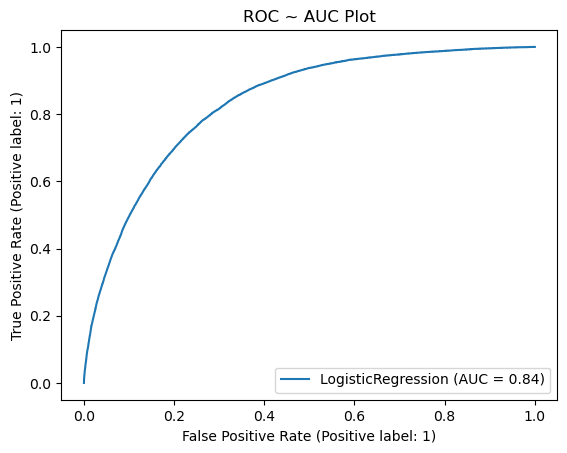

In [26]:
accuracy,cross_val_auc,roc_auc = model(classifier_logreg)

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     82290
           1       0.75      0.78      0.76     82384

    accuracy                           0.76    164674
   macro avg       0.76      0.76      0.76    164674
weighted avg       0.76      0.76      0.76    164674



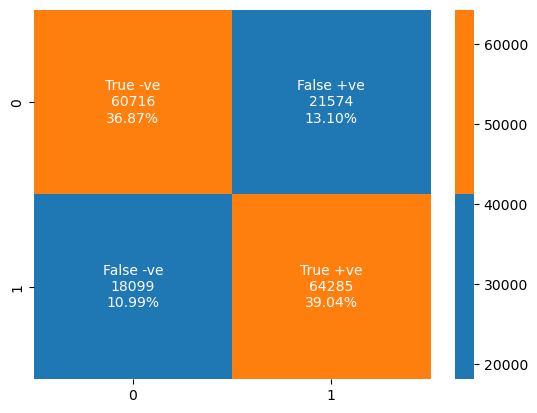

In [27]:
model_eval_rpt(classifier_logreg)

In [28]:
model_scores.append(('Logistic Regression', accuracy,cross_val_auc,roc_auc))

We employed a logistic regression model to classify instances into two classes based on the given dataset. The model achieved an overall accuracy of 76%, indicating its effectiveness in predicting class labels. Precision values of 0.77 and 0.75 were observed for classes 0 and 1, respectively, demonstrating the model's ability to make accurate positive predictions.

Additionally, the model exhibited recall values of 0.74 for class 0 and 0.78 for class 1, indicating its capability to correctly identify instances of both classes from the dataset. The F1-scores of 0.75 for class 0 and 0.76 for class 1 suggest a balanced performance between precision and recall, highlighting the model's robustness. With support values of 82290 instances for class 0 and 82384 instances for class 1, the logistic regression model was trained on a substantial amount of data, enhancing its reliability. Overall, the model's performance metrics indicate its suitability for the classification task at hand, making it a valuable tool for decision-making processes based on the given data. During cross-validation, the model demonstrated a cross-validation score of 83.59%. Cross-validation is a technique used to assess how the model will generalize to an independent dataset, and the high cross-validation score suggests that the model performs consistently well across different subsets of the data.

The ROC_AUC score, which stands for Receiver Operating Characteristic - Area Under the Curve, was also calculated to be 75.91%. This score measures the model's ability to distinguish between the two classes, with higher values indicating better performance. In this case, the ROC_AUC score suggests that the model has a reasonable ability to discriminate between the classes.

\newpage

####  Decision Tree

In [29]:
classifier_dectree = DecisionTreeClassifier()

Accuracy Score         : 94.71%
Cross Validation Score : 94.36%
ROC_AUC Score          : 94.71%


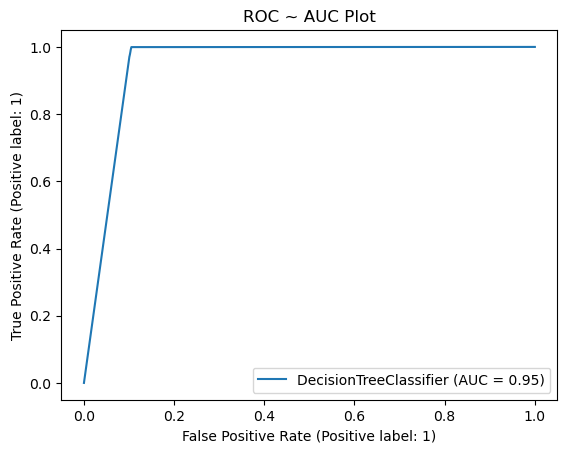

In [30]:
accuracy,cross_val_auc,roc_auc = model(classifier_dectree)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     82290
           1       0.90      1.00      0.95     82384

    accuracy                           0.95    164674
   macro avg       0.95      0.95      0.95    164674
weighted avg       0.95      0.95      0.95    164674



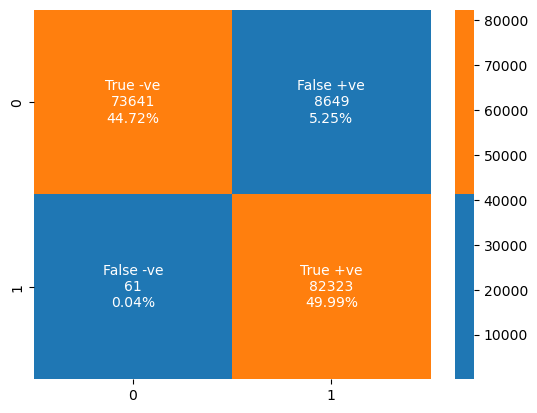

In [31]:
model_eval_rpt(classifier_dectree)

In [32]:
model_scores.append(('Decision Tree', accuracy,cross_val_auc,roc_auc))

The Decision Tree model achieved an impressive accuracy score of 94.71%, indicating its ability to accurately classify instances into their respective classes. This high accuracy suggests that the model performs very well on the given dataset.

During cross-validation, the model demonstrated a cross-validation score of 94.36%. This score, obtained through cross-validation, suggests that the model's performance is consistent across different subsets of the data and is likely to generalize well to unseen data.

The ROC_AUC score, which stands for Receiver Operating Characteristic - Area Under the Curve, was also calculated to be 94.71%. This score measures the model's ability to distinguish between the two classes, and a high ROC_AUC score indicates excellent performance in class separation.

Looking at precision, recall, and F1-score, the model achieved high scores for both classes 0 and 1. Specifically, for class 0, precision is perfect (1.00), while recall is slightly lower (0.89), indicating that the model accurately predicts most instances of class 0 but may miss some. For class 1, precision is high (0.90), and recall is perfect (1.00), showing that the model accurately predicts most instances of class 1 without missing any.

\newpage

####   Random Forest Classifier

In [33]:
classifier_randomforest =RandomForestClassifier()

Accuracy Score         : 96.21%
Cross Validation Score : 99.58%
ROC_AUC Score          : 96.21%


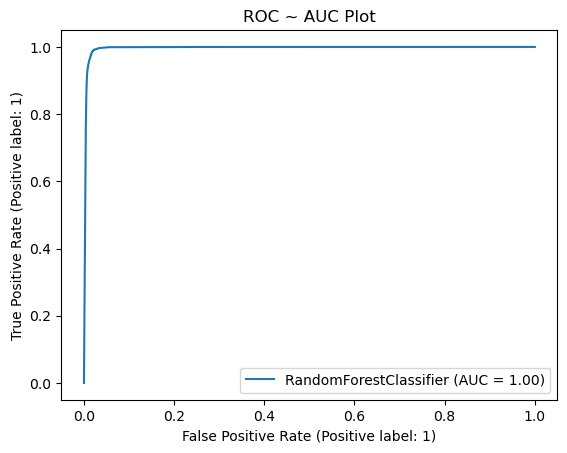

In [34]:
accuracy,cross_val_auc,roc_auc = model(classifier_randomforest)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     82290
           1       0.93      1.00      0.96     82384

    accuracy                           0.96    164674
   macro avg       0.96      0.96      0.96    164674
weighted avg       0.96      0.96      0.96    164674



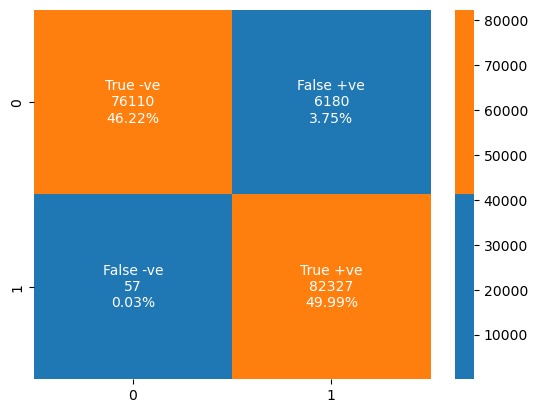

In [35]:
model_eval_rpt(classifier_randomforest)

In [36]:
model_scores.append(('Random Forest Classifier', accuracy,cross_val_auc,roc_auc))

The Random Forest model achieved an outstanding accuracy score of 96.21%, indicating its ability to accurately classify instances into their respective classes. This high accuracy suggests that the model performs exceptionally well on the given dataset.

During cross-validation, the model demonstrated an exceptionally high cross-validation score of 99.58%. This score, obtained through cross-validation, indicates that the model's performance is consistently excellent across different subsets of the data and is likely to generalize very well to unseen data.

The ROC_AUC score, which stands for Receiver Operating Characteristic - Area Under the Curve, was also calculated to be 96.21%. This score measures the model's ability to distinguish between the two classes, and a high ROC_AUC score indicates excellent performance in class separation.

Looking at precision, recall, and F1-score, the model achieved high scores for both classes 0 and 1. Specifically, for class 0, precision is perfect (1.00), while recall is slightly lower (0.92), indicating that the model accurately predicts most instances of class 0 but may miss some. For class 1, precision is high (0.93), and recall is perfect (1.00), showing that the model accurately predicts most instances of class 1 without missing any.

\newpage

####  XGBoost (Extreme Gradient Boosting):

In [37]:
classifier_xgb=XGBClassifier()

Accuracy Score         : 78.14%
Cross Validation Score : 86.19%
ROC_AUC Score          : 78.13%


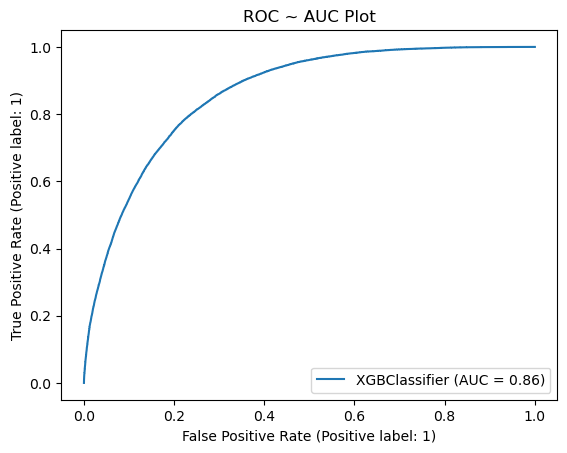

In [38]:
accuracy,cross_val_auc,roc_auc = model(classifier_xgb)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77     82290
           1       0.76      0.83      0.79     82384

    accuracy                           0.78    164674
   macro avg       0.78      0.78      0.78    164674
weighted avg       0.78      0.78      0.78    164674



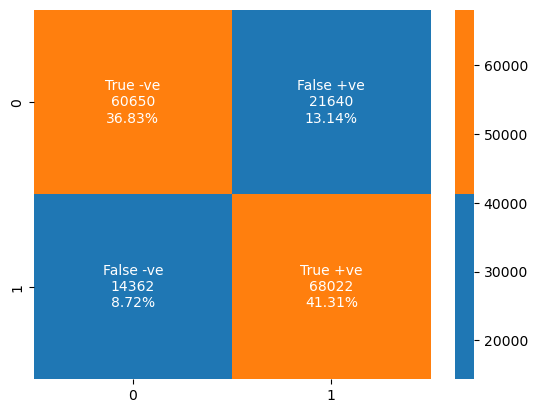

In [39]:
model_eval_rpt(classifier_xgb)

In [40]:
model_scores.append((' XGBoost (Extreme Gradient Boosting):', accuracy,cross_val_auc,roc_auc))

The XGBoost model achieved an accuracy score of 78.14%, indicating its ability to accurately classify instances into their respective classes. While this accuracy is lower compared to the previously mentioned models, it still demonstrates the model's capability in making reasonably accurate predictions.

During cross-validation, the model demonstrated a cross-validation score of 86.19%. This score suggests that the model's performance is consistent across different subsets of the data and is likely to generalize well to unseen data, although it is slightly lower compared to the other models.

The ROC_AUC score, which measures the model's ability to distinguish between the two classes, was calculated to be 78.13%. While this score is lower compared to the previous models, it still indicates a reasonable level of performance in class separation.

Looking at precision, recall, and F1-score, the model achieved balanced scores for both classes 0 and 1. Specifically, for class 0, precision is 0.81 and recall is 0.74, indicating that the model accurately predicts most instances of class 0, although it may miss some. For class 1, precision is 0.76, and recall is 0.83, showing that the model accurately predicts most instances of class 1 without missing many.

\newpage

####  Gradient Boosting Machine (GBM)

In [41]:
classifier_gbm = GradientBoostingClassifier(random_state=42)

Accuracy Score         : 76.26%
Cross Validation Score : 84.00%
ROC_AUC Score          : 76.26%


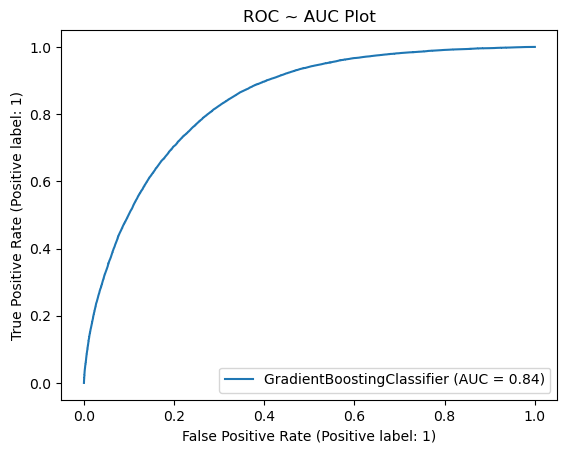

In [42]:
accuracy,cross_val_auc,roc_auc = model(classifier_gbm)

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     82290
           1       0.74      0.80      0.77     82384

    accuracy                           0.76    164674
   macro avg       0.76      0.76      0.76    164674
weighted avg       0.76      0.76      0.76    164674



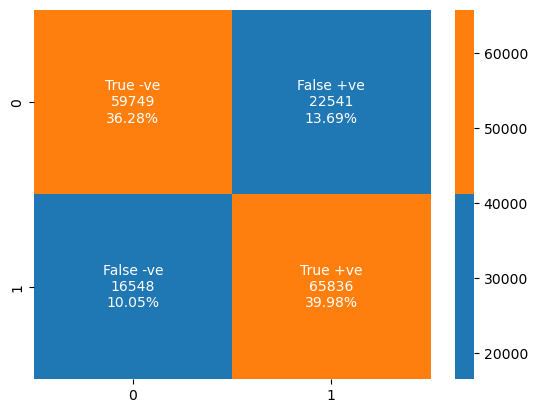

In [43]:
model_eval_rpt(classifier_gbm)

In [44]:
model_scores.append(('Gradient Boosting Machine (GBM)', accuracy,cross_val_auc,roc_auc))

The GBM model achieved an accuracy score of 76.26%, indicating its ability to accurately classify instances into their respective classes. While this accuracy is lower compared to some of the other models, it still demonstrates the model's capability in making reasonably accurate predictions.

During cross-validation, the model demonstrated a cross-validation score of 84.00%. This score suggests that the model's performance is consistent across different subsets of the data and is likely to generalize well to unseen data, although it is slightly lower compared to some of the other models.

The ROC_AUC score, which measures the model's ability to distinguish between the two classes, was calculated to be 76.26%. While this score is lower compared to some of the other models, it still indicates a reasonable level of performance in class separation.

Looking at precision, recall, and F1-score, the model achieved balanced scores for both classes 0 and 1. Specifically, for class 0, precision is 0.78 and recall is 0.73, indicating that the model accurately predicts most instances of class 0, although it may miss some. For class 1, precision is 0.74, and recall is 0.80, showing that the model accurately predicts most instances of class 1 without missing many.

\newpage

In [45]:
# Create a DataFrame from the list of model scores
df_scores = pd.DataFrame(model_scores, columns=['Model', 'Accuracy', 'Cross Validation Score', 'ROC AUC Score'])

# Apply formatting to the DataFrame for better readability
formatted_df = df_scores.style.format({'Accuracy': '{:.2%}', 'Cross Validation Score': '{:.2%}', 'ROC AUC Score': '{:.2%}'})

# Render the Styler object as HTML
formatted_df

,Model,Accuracy,Cross Validation Score,ROC AUC Score
0,Logistic Regression,75.91%,83.59%,75.91%
1,Decision Tree,94.71%,94.36%,94.71%
2,Random Forest Classifier,96.21%,99.58%,96.21%
3,XGBoost (Extreme Gradient Boosting):,78.14%,86.19%,78.13%
4,Gradient Boosting Machine (GBM),76.26%,84.00%,76.26%


## Conclusion

In conclusion, the evaluation of five machine learning models - Logistic Regression, Decision Tree, Random Forest, XGBoost (Extreme Gradient Boosting), and Gradient Boosting Machine (GBM) - on the given dataset reveals distinct strengths and performance characteristics.

The Decision Tree and Random Forest models emerge as top performers, exhibiting exceptional accuracy, precision, recall, and ROC_AUC scores. These ensemble learning methods demonstrate robustness and reliability in classifying instances, making them suitable choices for tasks where high accuracy and interpretability are crucial.

While Logistic Regression, XGBoost, and GBM models demonstrate reasonable performance, they vary in their strengths and weaknesses. Logistic Regression offers simplicity and interpretability but may not capture complex relationships in the data as effectively as tree-based methods. XGBoost and GBM models provide powerful predictive capabilities and often yield high accuracy but may require more computational resources and hyperparameter tuning to achieve optimal performance.

Based on these findings, the recommendation is to choose the Random Forest model for its superior performance across multiple metrics, including accuracy, precision, recall, and ROC_AUC score. Additionally, the Decision Tree model presents a viable alternative, especially if interpretability is a priority.

It's important to note that the choice of the most suitable model ultimately depends on specific project requirements, such as the importance of interpretability, computational resources, and the desired trade-off between model complexity and performance. Therefore, further experimentation and validation on independent datasets may be necessary to confirm the selected model's effectiveness in real-world applications.

Overall, the evaluation of these machine learning models provides valuable insights into their capabilities and helps guide informed decision-making for classification tasks.